# Analyze Serie A Fantasy League Data

In [12]:
# Imports
import os

from ipywidgets import widgets
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import mpldatacursor
import numpy as np
import pandas as pd
import seaborn as sns

In [15]:
# Constants
FOLDER_DATA = '../data'
FILENAME_DATA = 'dataset-multiyear.csv'

# %matplotlib inline
%matplotlib notebook
sns.set()

## Load and process data

In [3]:
# Load data
filepath_data = os.path.join(FOLDER_DATA, FILENAME_DATA)
df = pd.read_csv(filepath_data)

In [4]:
# Process data

# Remove players who played less than 10 games last year
N_MIN_GAMES = 10
df = df[df['Pg1617'] > N_MIN_GAMES]

# Keep players who played (at least) 2 most recent years
# or had a score equal to 0 last year
cols_mf = ['Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
idxs_to_remove_last_seasons = df[cols_mf[-2:]].isnull().any(axis=1)  # not played last 2 seasons
idxs_to_remove_zeros = df[cols_mf[-1]] == 0  # score is 0 for last season
idxs_to_remove = idxs_to_remove_last_seasons | idxs_to_remove_zeros
df_updated = df[~idxs_to_remove]

# Preview data
df_updated.head()

,Name,Yc1314,Yc1415,Yc1516,Yc1617,Ass1516,Ass1617,Asr1314,Asr1415,Asr1516,...,Pk1516,Pk1617,Ps1314,Ps1415,Ps1516,Ps1617,Team1314,Team1415,Team1516,Team1617
0,ABATE,1.0,5.0,7.0,2.0,0.0,0.0,0.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,MILAN,MILAN,Milan,Milan
2,ACERBI,1.0,7.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,SASSUOLO,SASSUOLO,Sassuolo,Sassuolo
5,ACQUAH,6.0,9.0,9.0,2.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,PARMA,SAMPDORIA,Torino,Torino
8,ADNAN,NaN,NaN,6.0,2.0,0.0,0.0,NaN,NaN,1.0,...,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,Udinese,Udinese
17,ALBIOL,5.0,10.0,10.0,8.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NAPOLI,NAPOLI,Napoli,Napoli


## Analyze data

### Trends

In [5]:
# Players with constant positive trend

COLS_TRENDS = ['Name', 
               'Delta1', 'Delta2', 'Delta3', 
               'Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']

data_positive_trend = []
for id_player in df_updated.index:  # for each player...
    player = df_updated.loc[id_player]
    # Calculate score difference between seasons
    curr_mf = player[cols_mf].dropna()
    curr_deltas = [0] * (4 - len(curr_mf))  # delta == 0 for missing years
    curr_deltas.extend([curr_mf[i+1] - curr_mf[i] \
                        for i in xrange(len(curr_mf) - 1)])
    # Check if player has positive differences only...
    n_negative_deltas = sum(np.array(curr_deltas) < 0)
    if n_negative_deltas == 0:
        # ...and add him to the dataset
        row = [player['Name']]
        row.extend(curr_deltas)
        row.extend(player[cols_mf])
        data_positive_trend.append(row)

# Create DataFrame and preview it
df_positive_trend = pd.DataFrame(data=data_positive_trend, 
                                 columns=COLS_TRENDS)
print "Number of players with positive trend:", len(df_positive_trend)
df_positive_trend.head()

Number of players with positive trend: 58


,Name,Delta1,Delta2,Delta3,Sf1314,Sf1415,Sf1516,Sf1617
0,ANTEI,0.19,0.09,0.13,5.52,5.71,5.80,5.93
1,BABACAR,0.00,0.10,0.37,NaN,7.08,7.18,7.55
2,BADELJ,0.00,0.27,0.10,NaN,5.71,5.98,6.08
3,BALOGH,0.00,0.00,0.27,NaN,NaN,5.00,5.27
4,BARRETO E,0.00,0.00,0.51,NaN,NaN,5.57,6.08


<IPython.core.display.Javascript object>


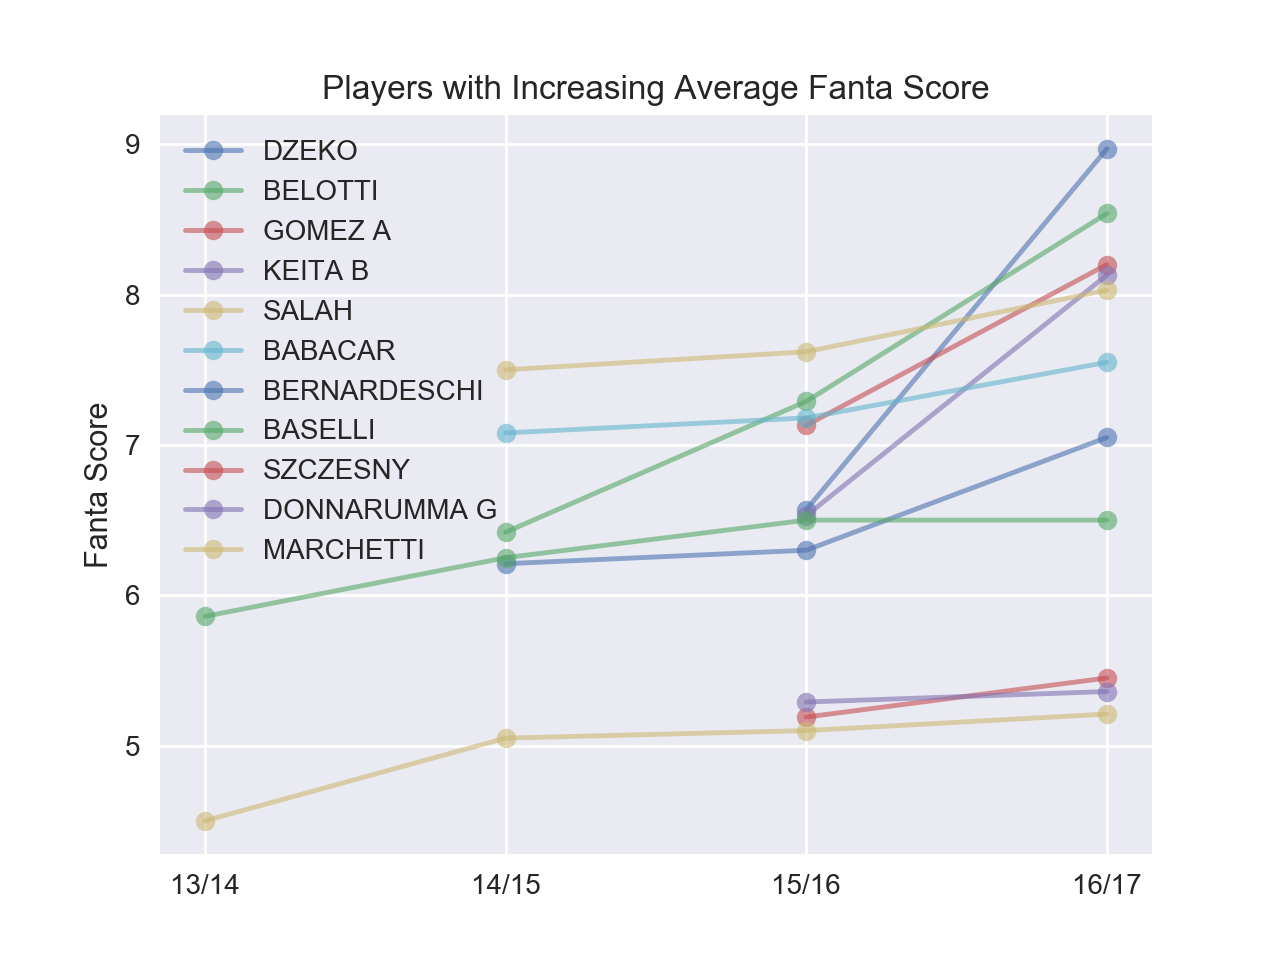

In [28]:
# Plot positive trends

X_TICKS = ['13/14', '14/15', '15/16', '16/17']
names = ['DZEKO',
         'BELOTTI',
         'SALAH',
         'GOMEZ A',
         'KEITA B',
         'BABACAR',
         'BERNARDESCHI',
         'BASELLI',
         'DONNARUMMA G',
         'SZCZESNY',
         'MARCHETTI']
# names = []

# Get data
if len(names) > 0:
    data = df_positive_trend[df_positive_trend['Name'].isin(names)]
    data = data.sort_values(['Sf1617'], ascending=False)
    names = data['Name'].values
    data = data.values[:, 4:]
else:
    data = df_positive_trend.values[:, 4:]

# Plot data
fig, ax = plt.subplots()
for i_row, row in enumerate(data):  # for each player...
    if len(names) > 0:
        curr_label = names[i_row]
    else:
        curr_label = df_positive_trend.iloc[i_row, :]['Name']
    ax.plot(row, marker='o', alpha=0.6, label=curr_label)
    
# Initialize interactive tooltip
mpldatacursor.datacursor(formatter='{label}'.format)

# Add title and labels
plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Players with Increasing Average Fanta Score')
plt.ylabel('Fanta Score')
plt.legend()

In [19]:
# Players with constant negative trend

COLS_TRENDS = ['Name', 
               'Delta1', 'Delta2', 'Delta3', 
               'Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']

data_negative_trend = []
for id_player in df_updated.index:  # for each player...
    player = df_updated.loc[id_player]
    # Calculate score difference between seasons
    curr_mf = player[cols_mf].dropna()
    curr_deltas = [0] * (4 - len(curr_mf))  # delta == 0 for missing years
    curr_deltas.extend([curr_mf[i+1] - curr_mf[i] \
                        for i in xrange(len(curr_mf) - 1)])
    # Check if player has negative differences only...
    n_positive_deltas = sum(np.array(curr_deltas) > 0)
    if n_positive_deltas == 0:
        # ...and add him to the dataset
        row = [player['Name']]
        row.extend(curr_deltas)
        row.extend(player[cols_mf])
        data_negative_trend.append(row)
        
# Create DataFrame and preview it
df_negative_trend = pd.DataFrame(data=data_negative_trend, 
                                 columns=COLS_TRENDS)
print "Number of players with negative trend:", len(df_negative_trend)
df_negative_trend.head()

Number of players with negative trend: 46


,Name,Delta1,Delta2,Delta3,Sf1314,Sf1415,Sf1516,Sf1617
0,ADNAN,0.0,0.0,-0.51,NaN,NaN,6.05,5.54
1,ALEX SANDRO,0.0,0.0,-0.32,NaN,NaN,6.74,6.42
2,ALVAREZ R,0.0,0.0,-0.10,NaN,NaN,6.19,6.09
3,ANSALDI,0.0,0.0,-0.48,NaN,NaN,6.10,5.62
4,BACCA,0.0,0.0,-0.67,NaN,NaN,7.54,6.87


<IPython.core.display.Javascript object>


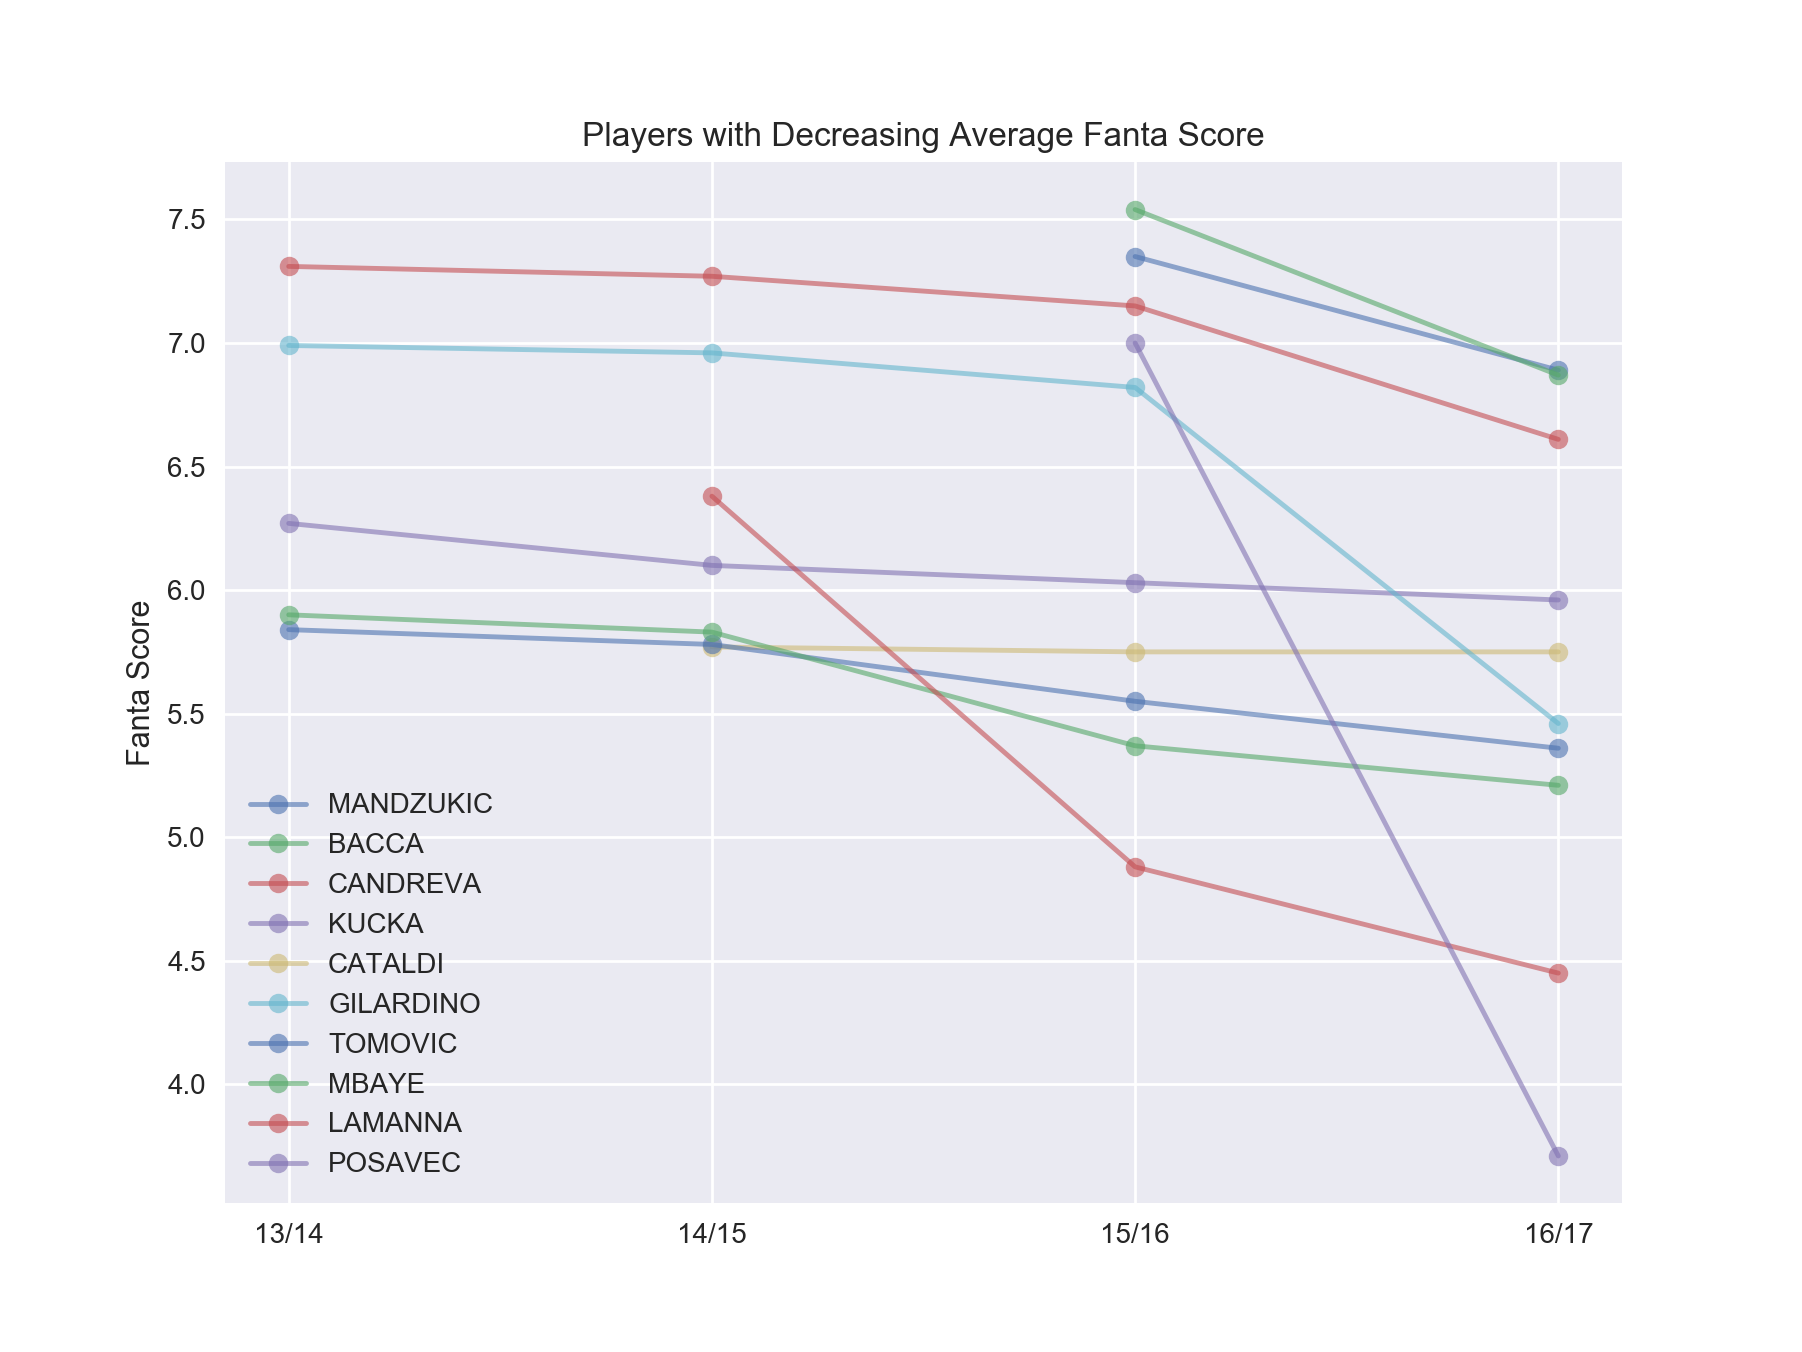

In [30]:
# Plot negative trends

X_TICKS = ['13/14', '14/15', '15/16', '16/17']
names = ['BACCA',
         'MANDZUKIC',
         'BIZARRI',
         'POSAVEC',
         'LAMANNA',
         'CANDREVA',
         'GILARDINO',
         'KUCKA',
         'MBAYE',
         'TOMOVIC',
         'CATALDI']
# names = []

# Get data
if len(names) > 0:
    data = df_negative_trend[df_negative_trend['Name'].isin(names)]
    data = data.sort_values(['Sf1617'], ascending=False)
    names = data['Name'].values
    data = data.values[:, 4:]
else:
    data = df_negative_trend.values[:, 4:]

# Plot data
fig, ax = plt.subplots()
for i_row, row in enumerate(data):
    if len(names) > 0:
        curr_label = names[i_row]
    else:
        curr_label = df_positive_trend.iloc[i_row, :]['Name']
    ax.plot(row, marker='o', alpha=0.6, label=curr_label)
    
# Initialize interactive tooltip
mpldatacursor.datacursor(formatter='{label}'.format)

# Add title and labels
plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Players with Decreasing Average Fanta Score')
plt.ylabel('Fanta Score')
plt.legend()

### Deltas

In [31]:
# Players' delta - difference between first and last season

COLS_MF = ['Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
COLS_DELTAS = ['Name', 'Delta', 'Squadra1617',
               'Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
data_deltas = []
for id_player in df_updated.index:  # for each player...
    player = df_updated.loc[id_player]
    # Calculate delta
    curr_mf = player[COLS_MF].dropna()
    curr_delta = curr_mf[-1] - curr_mf[0]
    # Append to dataset
    row = [player['Name']]
    row.append(curr_delta)
    row.append(player['Team1617'])
    row.extend(player[COLS_MF])
    data_deltas.append(row)
    
# Create DataFrame
df_deltas = pd.DataFrame(data=data_deltas, columns=COLS_DELTAS)
df_deltas = df_deltas.sort_values(['Delta'])  # sort by delta
df_deltas.head()

,Name,Delta,Squadra1617,Sf1314,Sf1415,Sf1516,Sf1617
209,POSAVEC,-3.29,Palermo,NaN,NaN,7.00,3.71
148,LAMANNA,-1.93,Genoa,NaN,6.38,4.88,4.45
32,BIZZARRI,-1.86,Pescara,NaN,5.41,5.10,3.55
79,DESTRO,-1.82,Bologna,8.44,6.63,6.65,6.62
191,PALACIO,-1.66,Inter,7.57,6.53,6.55,5.91


<IPython.core.display.Javascript object>


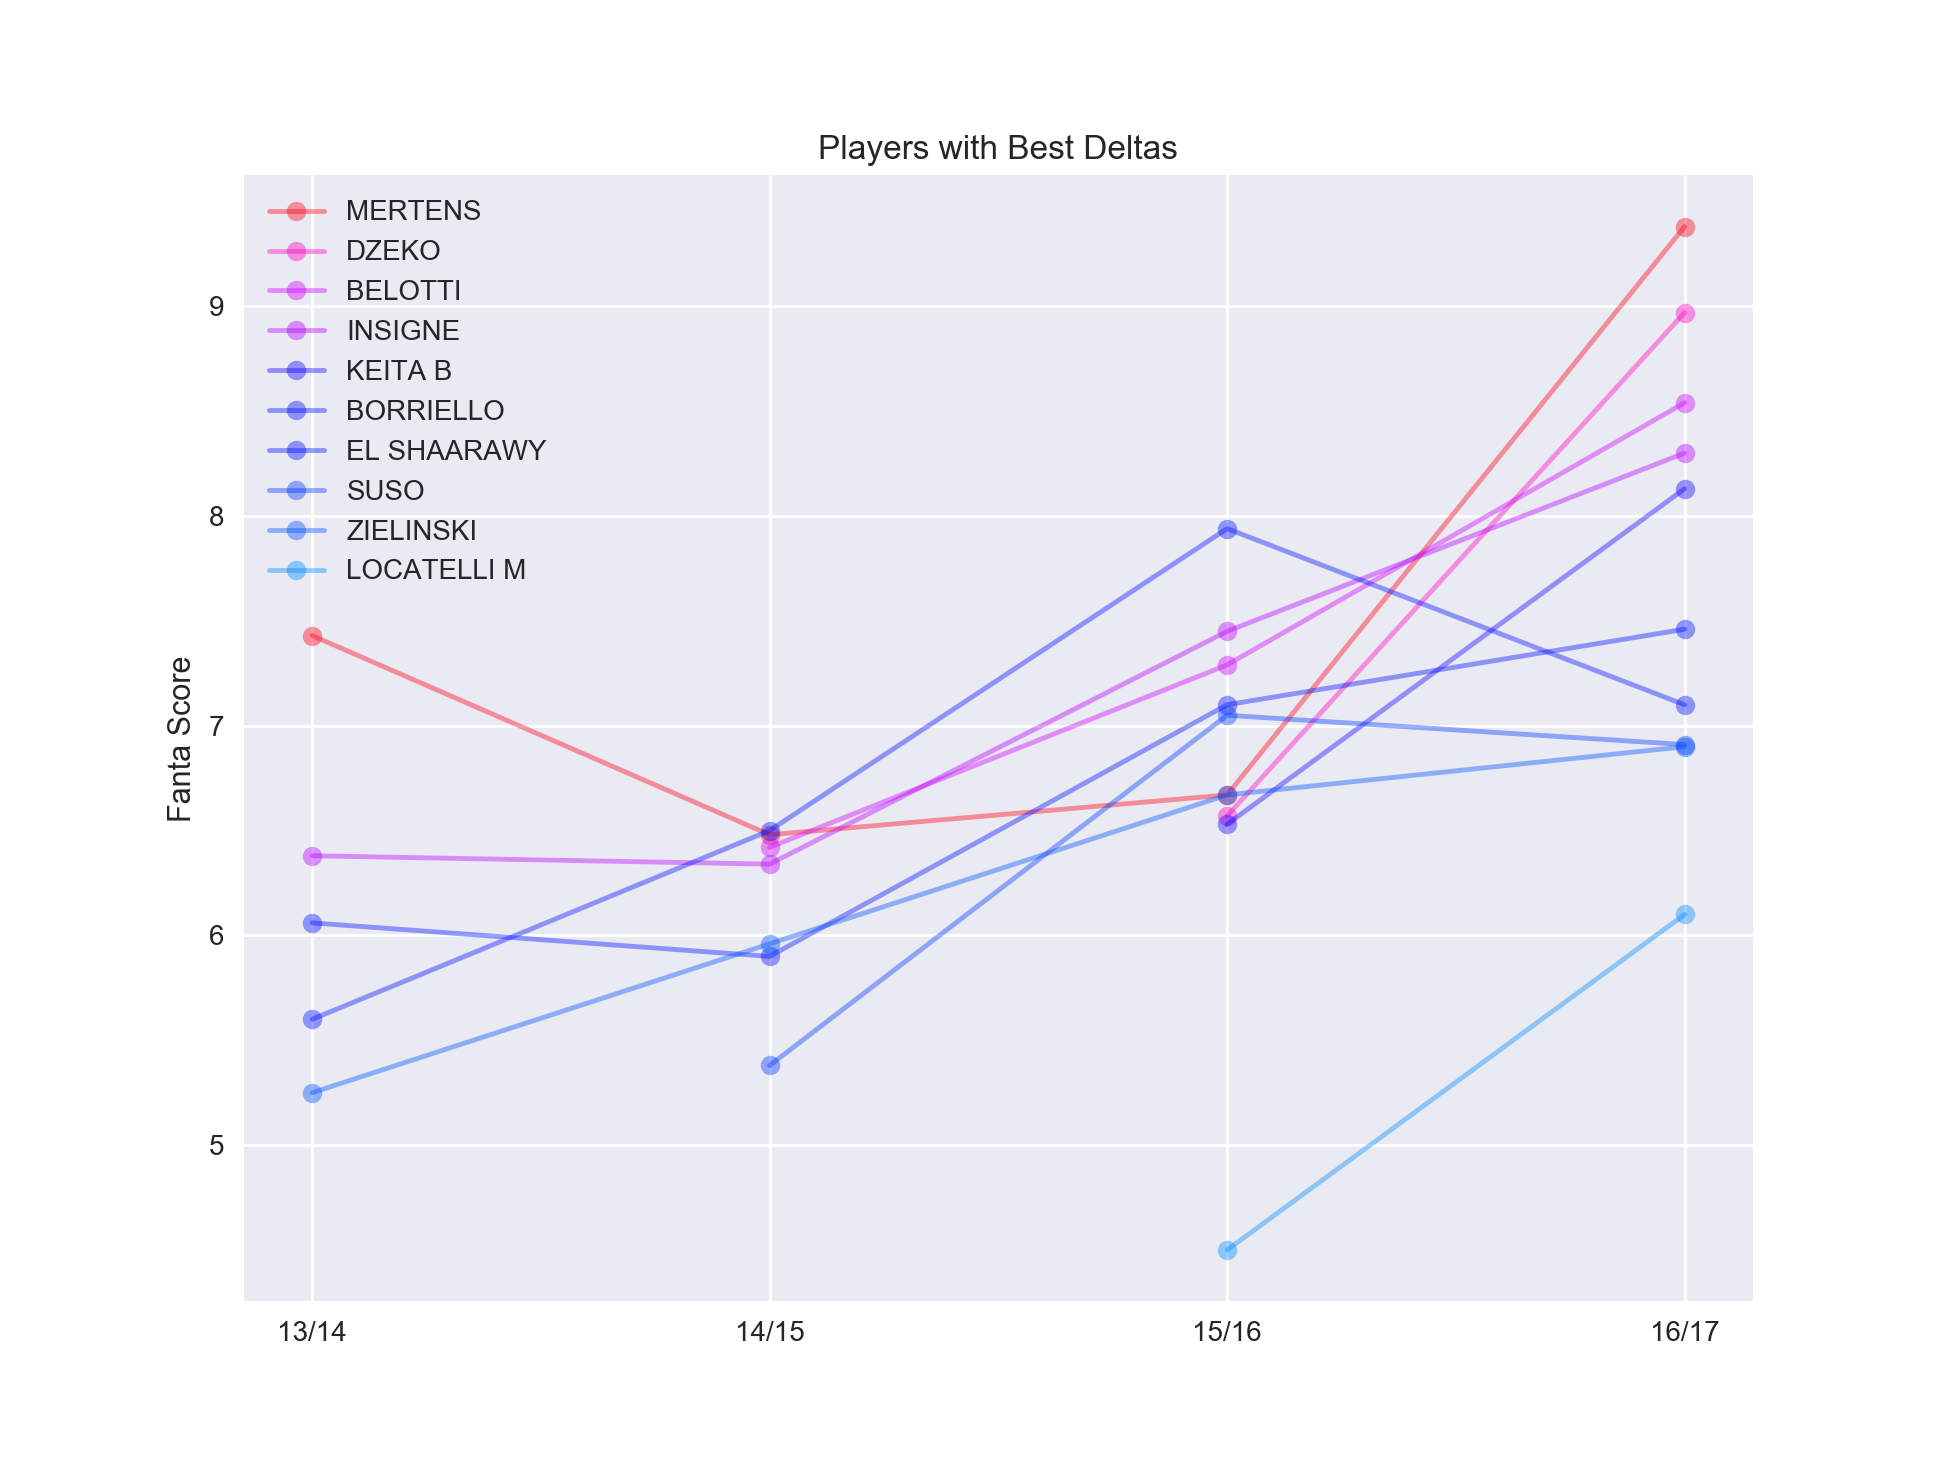

In [43]:
# Players with best positive deltas

X_TICKS = ['13/14', '14/15', '15/16', '16/17']

# Get data
N = 10 + 1
df_deltas_best = df_deltas.iloc[range(len(df_deltas)-1, len(df_deltas)-N, -1), :]
data = df_deltas_best.sort_values(['Sf1617'], ascending=False)
labels = data['Name'].values
data = data.values[:, 3:]
delta_max = df_deltas_best['Delta'].max()

# Plot data
fig, ax = plt.subplots()
for i_row, row in enumerate(data):  # for each player...
    curr_delta = df_deltas_best.iloc[i_row, :]['Delta']
    curr_label = labels[i_row]
    curr_col = cm.hsv(curr_delta / delta_max)
    ax.plot(row, marker='o', 
            c=curr_col, alpha=0.4,
            label=curr_label)
    
# Initialize interactive tooltip
mpldatacursor.datacursor(formatter='{label}'.format)

# Add title and labels
plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Players with Best Deltas')
plt.ylabel('Fanta Score')
plt.legend()

<IPython.core.display.Javascript object>


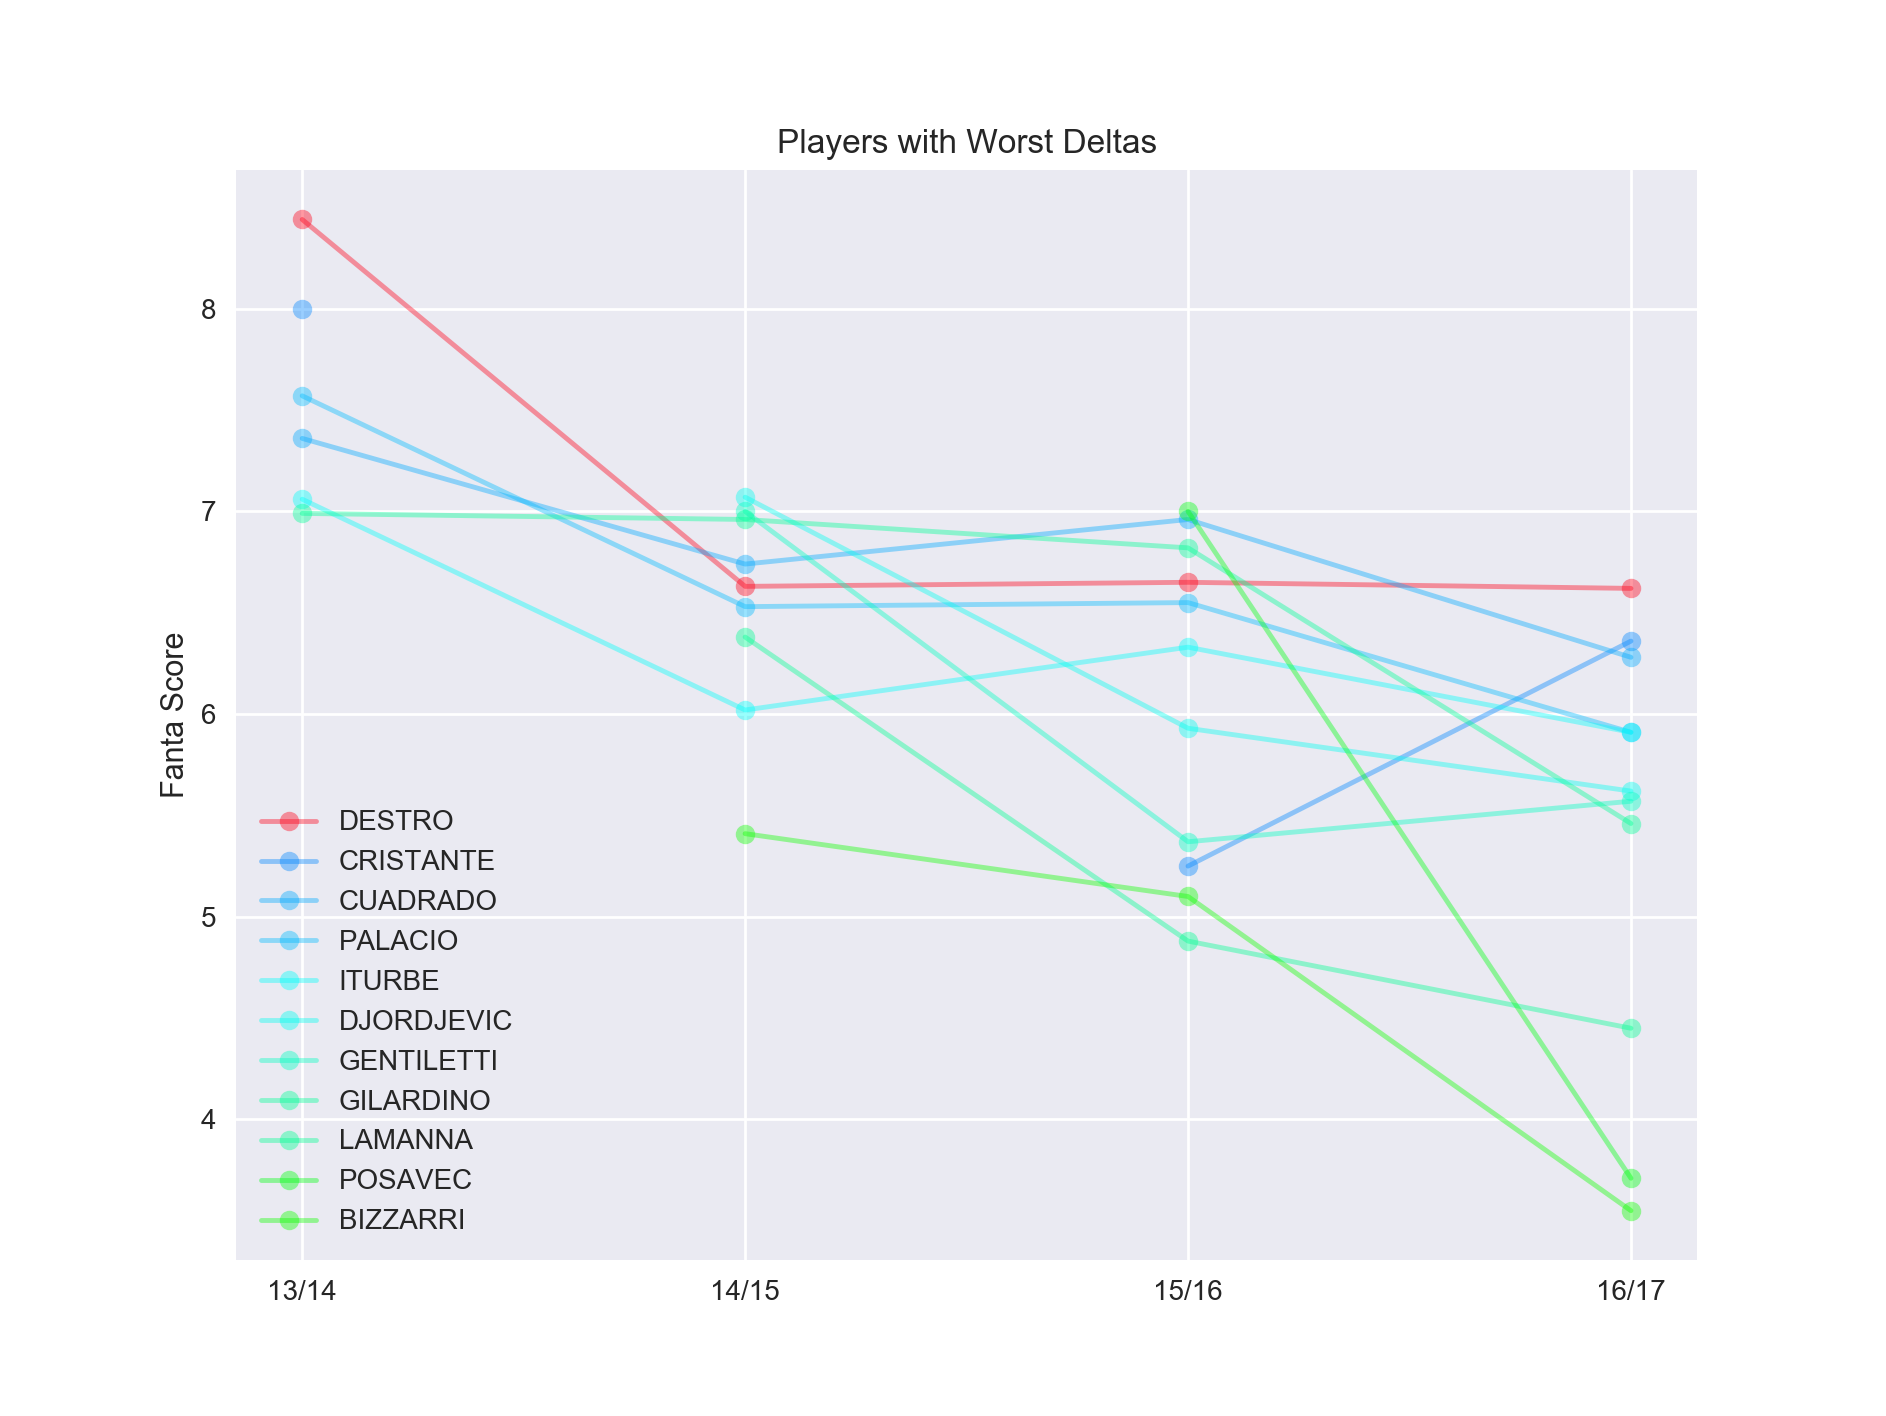

In [45]:
# Players with worst deltas

X_TICKS = ['13/14', '14/15', '15/16', '16/17']

# Get data
N = 10 + 1
df_deltas_worst = df_deltas.iloc[:N, :]
data = df_deltas_worst.sort_values(['Sf1617'], ascending=False)
labels = data['Name'].values
data = data.values[:, 3:]
delta_min = df_deltas_worst['Delta'].min()

# Plot data
fig, ax = plt.subplots()
for i_row, row in enumerate(data):  # for each player...
    curr_delta = df_deltas_worst.iloc[i_row, :]['Delta']
    curr_label = labels[i_row]
    curr_col = cm.hsv(abs(curr_delta / delta_min))
    ax.plot(row, marker='o', 
            c=curr_col, alpha=0.4,
            label=curr_label)
    
# Initialize interactive tooltip
mpldatacursor.datacursor(formatter='{label}'.format)

# Add title and labels
plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Players with Worst Deltas')
plt.ylabel('Fanta Score')
plt.legend()

## Career Mean

In [38]:
# Players' global mean

COLS_MF = ['Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
COLS_MEANS = ['Name', 'Mean', 'Squadra1617', 'R1617',
               'Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
data_means = []
for id_player in df_updated.index:  # for each player...
    player = df_updated.loc[id_player]
    # Calculate mean
    curr_mf = player[COLS_MF].dropna()
    curr_mean = np.mean(curr_mf)
    # Append to dataset
    row = [player['Name']]
    row.append(curr_mean)
    row.append(player['Team1617'])
    row.append(player['R1617'])
    row.extend(player[COLS_MF])
    data_means.append(row)
    
# Create DataFrame
df_means = pd.DataFrame(data=data_means, columns=COLS_MEANS)
df_means = df_means.sort_values(['Mean'])  # sort by delta
df_means.head()

,Name,Mean,Squadra1617,R1617,Sf1314,Sf1415,Sf1516,Sf1617
216,RAFAEL,4.600000,Cagliari,G,4.46,4.72,4.08,5.14
32,BIZZARRI,4.686667,Pescara,G,NaN,5.41,5.10,3.55
236,SORRENTINO,4.713333,Chievo,G,NaN,4.74,4.69,4.71
70,DA COSTA,4.750000,Bologna,G,4.50,NaN,5.00,4.75
139,KARNEZIS,4.793333,Udinese,G,NaN,5.05,4.63,4.70


<IPython.core.display.Javascript object>


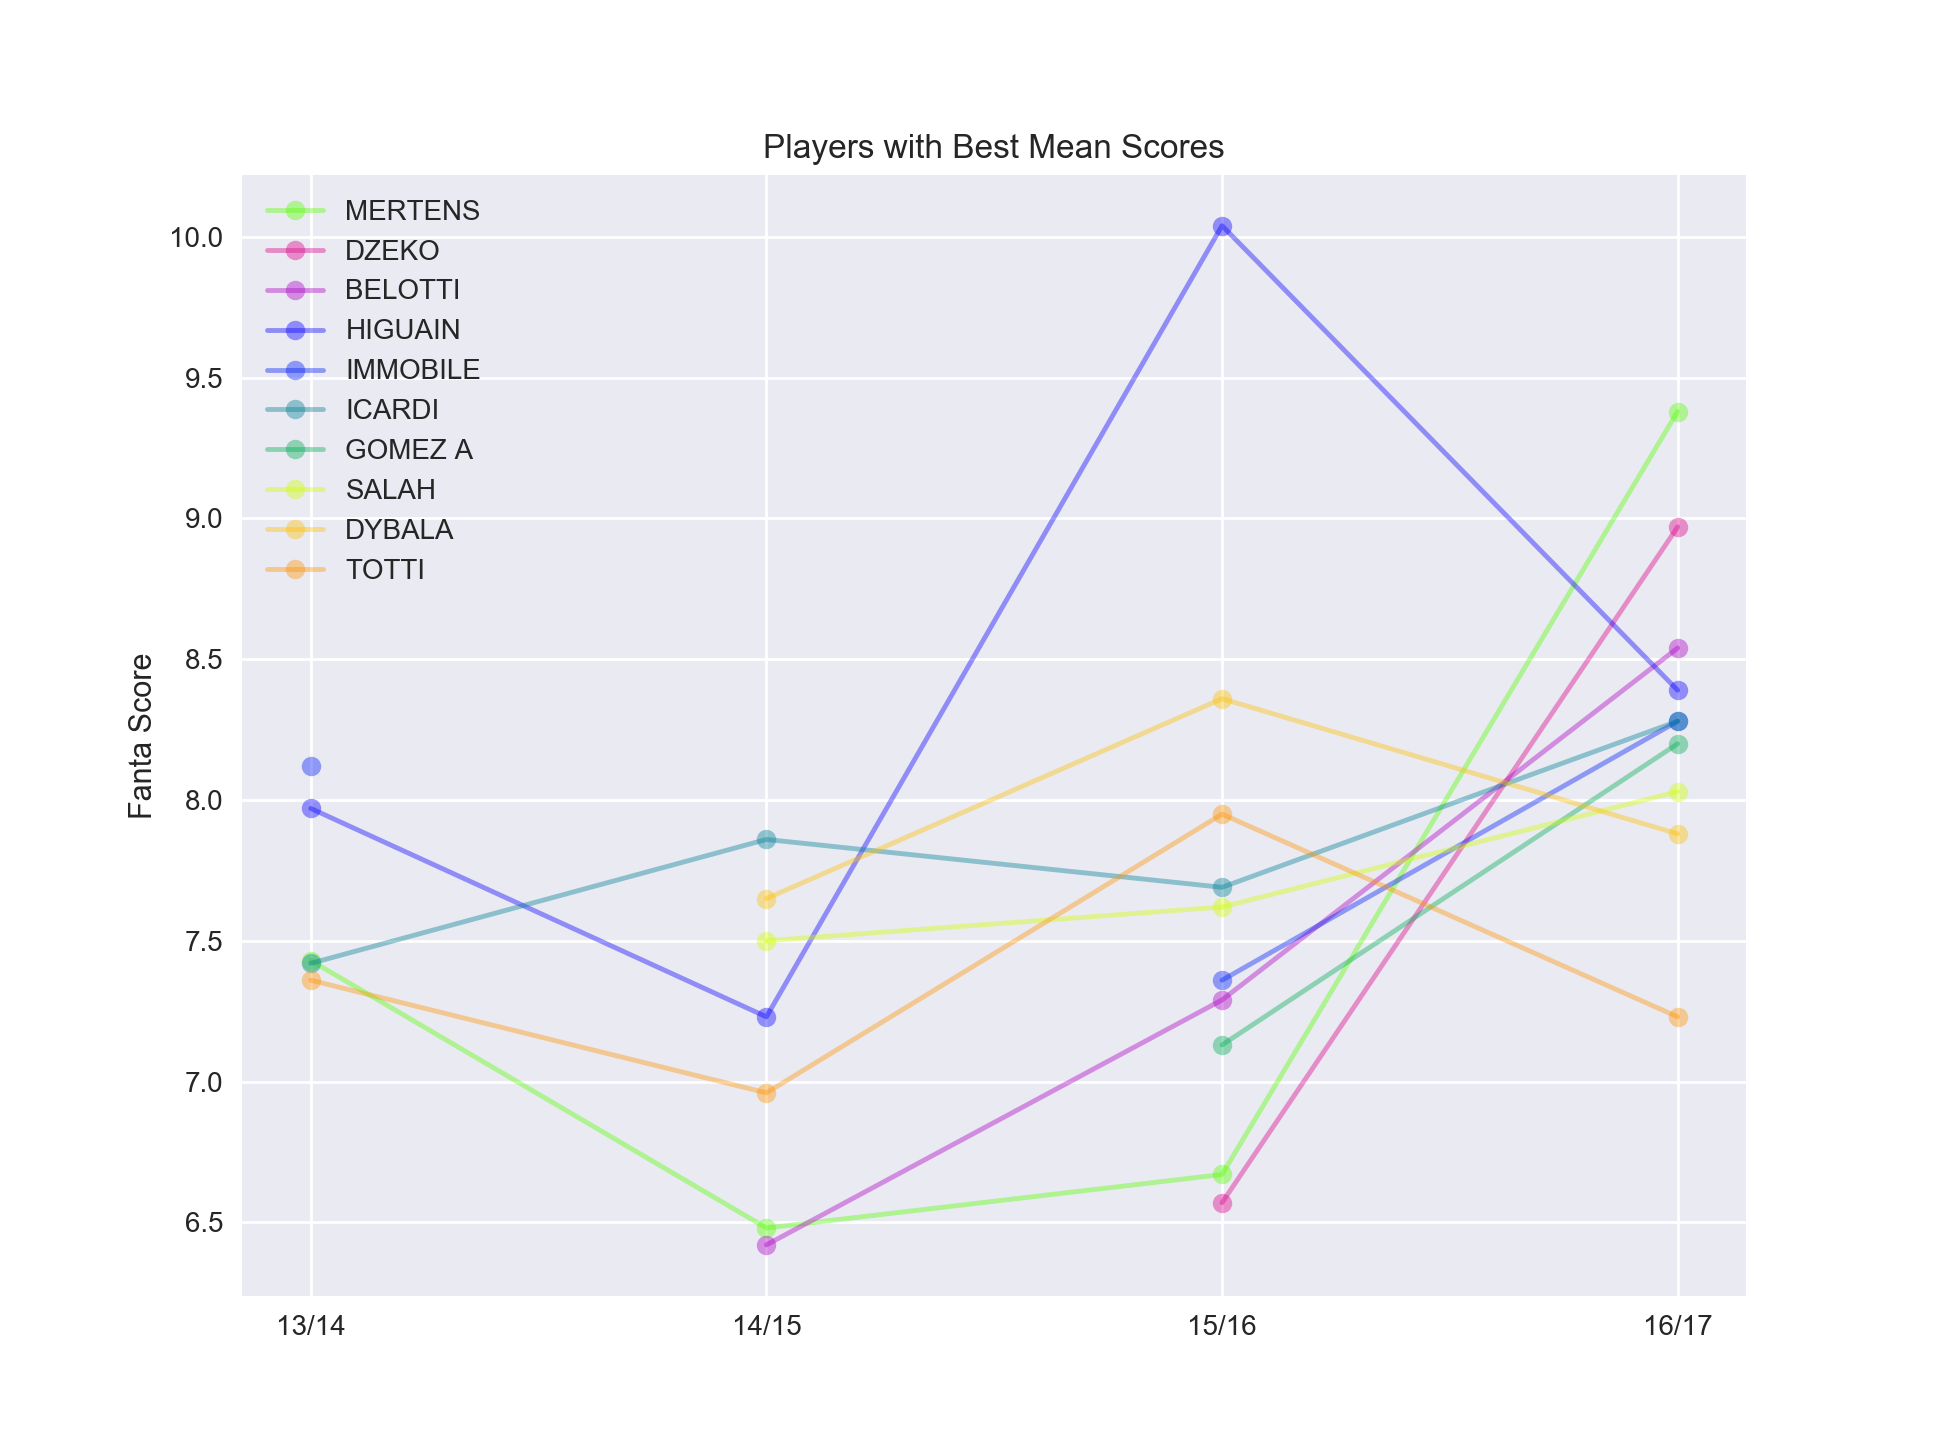

In [44]:
# Players with best mean scores

X_TICKS = ['13/14', '14/15', '15/16', '16/17']

# Get data
N = 10 + 1
df_means_best = df_means.iloc[range(len(df_means)-1, len(df_means)-N, -1), :]
data = df_means_best.sort_values(['Sf1617'], ascending=False)
labels = data['Name'].values
data = data.values[:, 4:]
mean_max = df_means_best['Mean'].max()

# Plot data
fig, ax = plt.subplots()
for i_row, row in enumerate(data):  # for each player...
    curr_mean = df_means_best.iloc[i_row, :]['Mean']
    curr_label = labels[i_row]
    curr_col = cm.prism(curr_mean / mean_max)
    ax.plot(row, marker='o', 
            c=curr_col, alpha=0.4,
            label=curr_label)
    
# Initialize interactive tooltip
mpldatacursor.datacursor(formatter='{label}'.format)

# Add title and labels
plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Players with Best Mean Scores')
plt.ylabel('Fanta Score')
plt.legend()

<IPython.core.display.Javascript object>


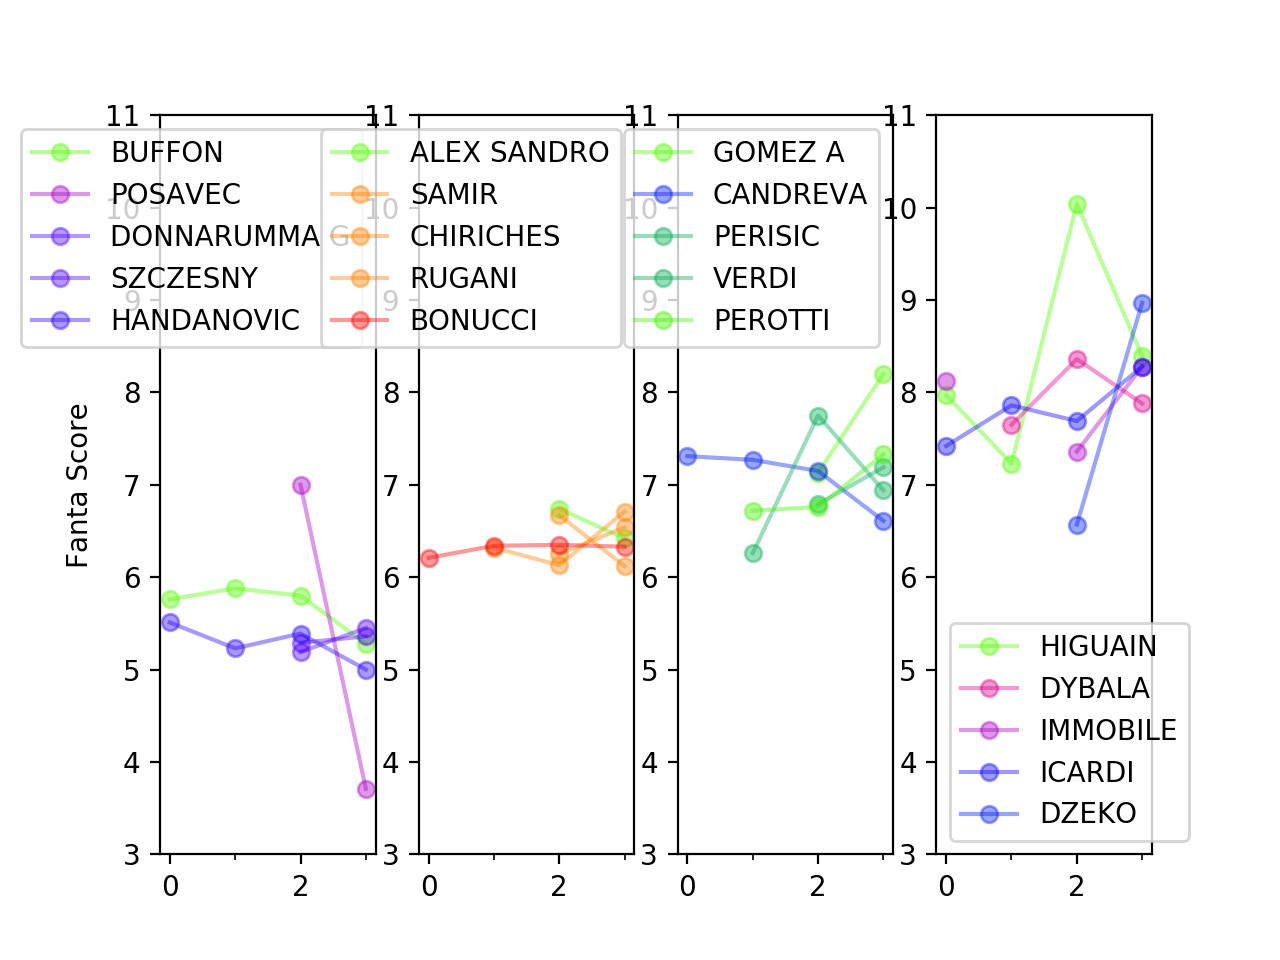

In [25]:
# Best mean scores by role

# Constants
ROLES = ['G', 'D', 'M', 'F']
N = 5 + 1

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax = (ax1, ax2, ax3, ax4)

for (i_role, role) in enumerate(ROLES):  # for each role...
    # Get data
    df_means_role = df_means[df_means['R1617'] == role]
    df_means_best_role = df_means_role.iloc[range(len(df_means_role)-1, len(df_means_role)-N, -1), :]
    data = df_means_best_role.values[:, 4:]
    mean_max = df_means_best_role['Mean'].max()

    # Plot data
    for i_row, row in enumerate(data):  # for each player...
        curr_mean = df_means_best_role.iloc[i_row, :]['Mean']
        curr_label = df_means_best_role.iloc[i_row, :]['Name']
        curr_col = cm.prism(curr_mean / mean_max)
        ax[i_role].plot(row, marker='o', 
                        c=curr_col, alpha=0.4,
                        label=curr_label)

    # Initialize interactive tooltip
    mpldatacursor.datacursor(formatter='{label}'.format)

    # Add title and labels
    ax[i_role].set_xticks(range(len(cols_mf)), cols_mf)
#     plt.title('Players with Best Mean Scores')
    if i_role == 0:
        ax[i_role].set_ylabel('Fanta Score')
    ax[i_role].legend()
    ax[i_role].set_ylim([3, 11])

<IPython.core.display.Javascript object>


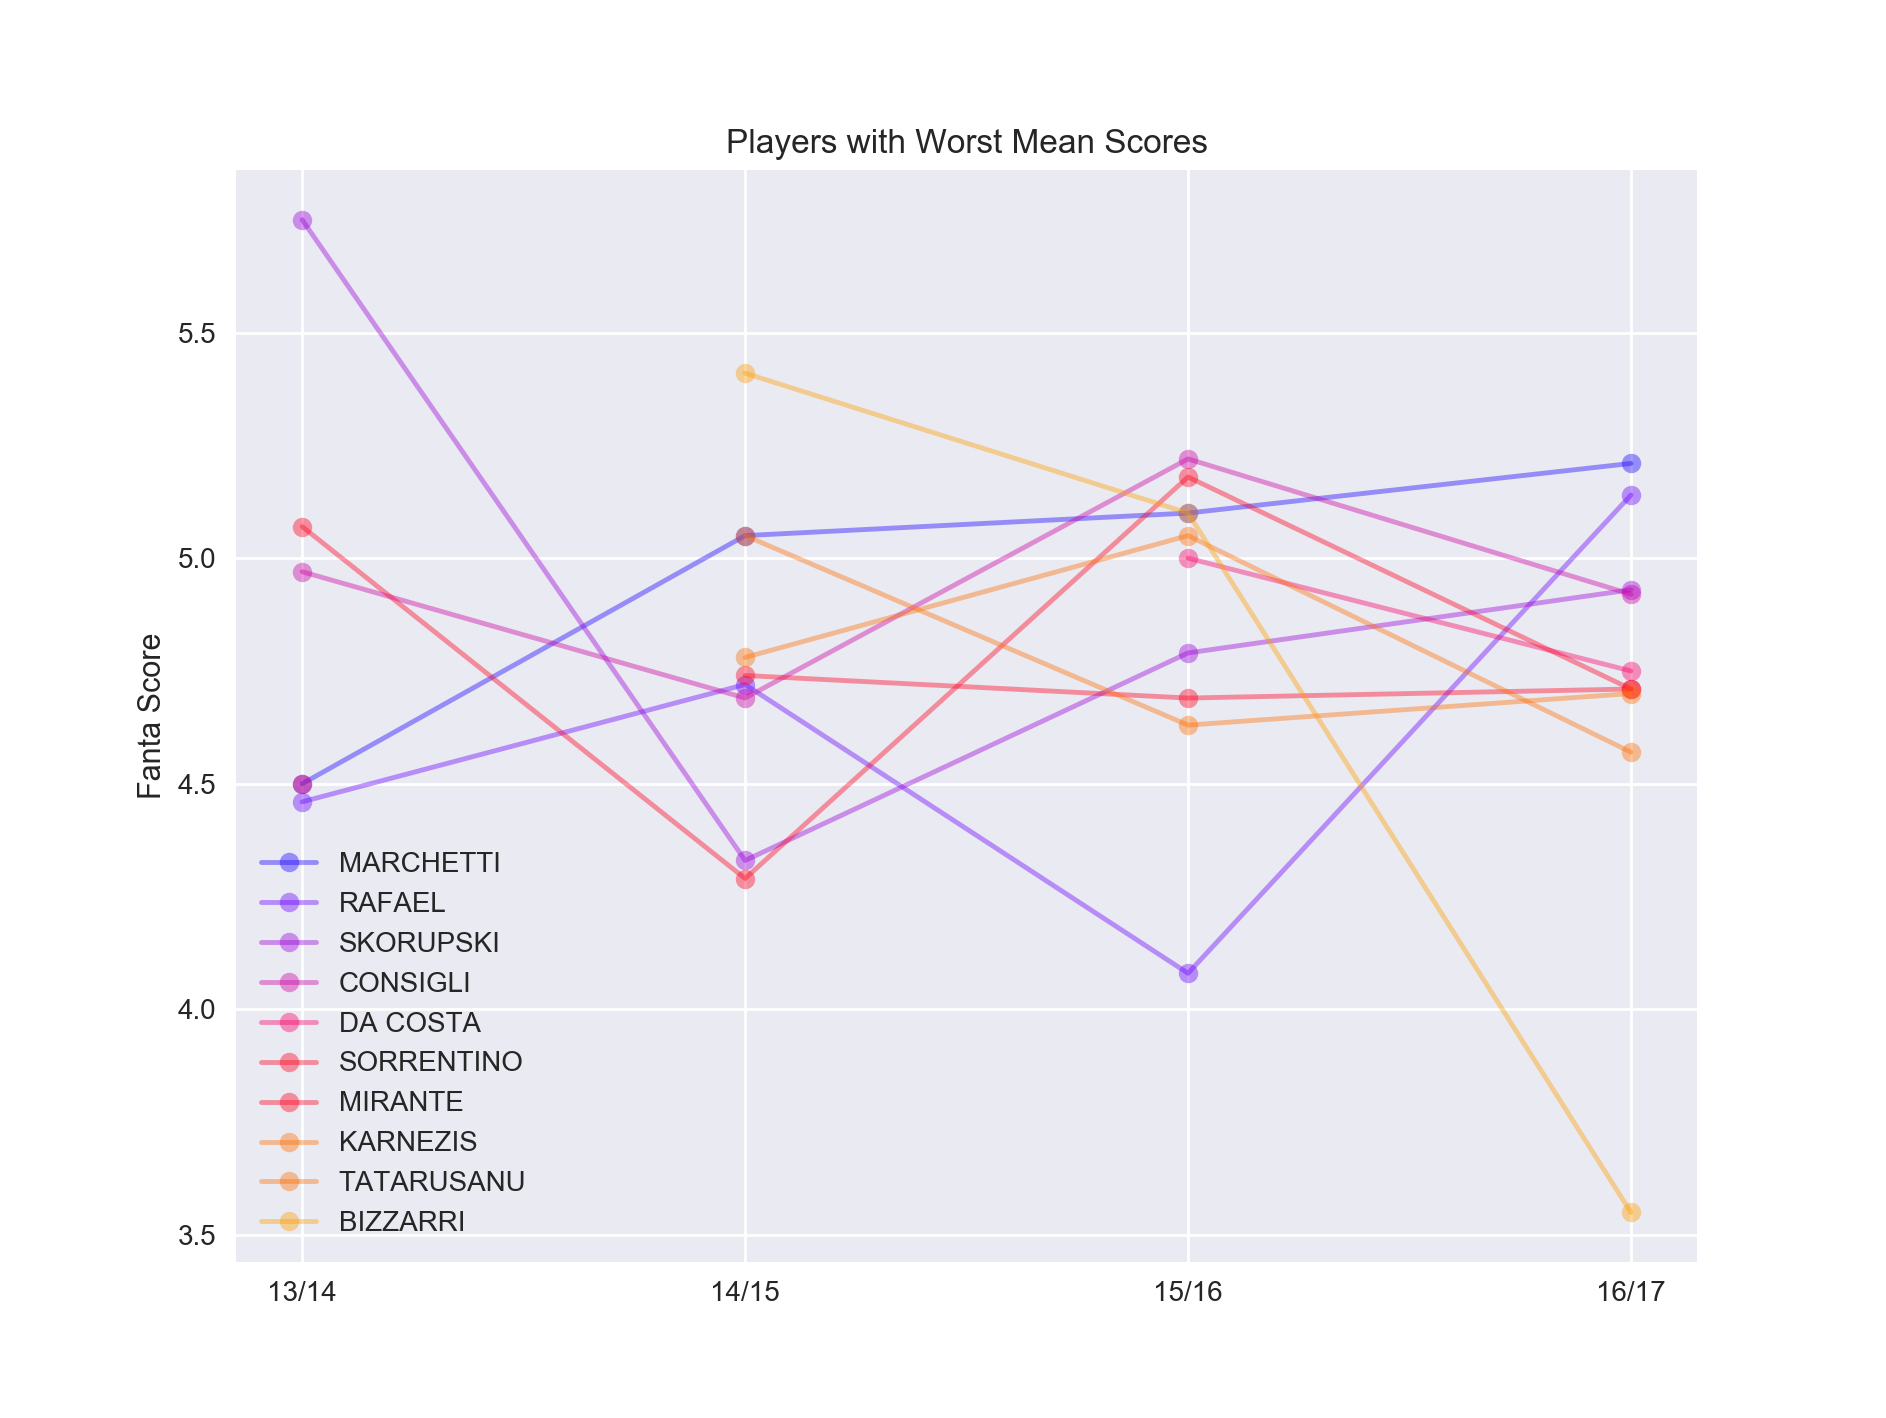

In [46]:
# Players with worst mean scores

X_TICKS  = ['13/14', '14/15', '15/16', '16/17']

# Get data
N = 10
df_means.iloc[:N, :]

# Get data
N = 10
df_means_worst = df_means.iloc[:N, :]
data = df_means_worst.sort_values(['Sf1617'], ascending=False)
labels = data['Name'].values
data = data.values[:, 4:]
mean_max = df_means['Mean'].max()

# Plot data
fig, ax = plt.subplots()
for i_row, row in enumerate(data):  # for each player...
    curr_mean = df_means_worst.iloc[i_row, :]['Mean']
    curr_label = labels[i_row]
    curr_col = cm.prism(curr_mean / mean_max)
    ax.plot(row, marker='o', 
            c=curr_col, alpha=0.4,
            label=curr_label)
    
# Initialize interactive tooltip
mpldatacursor.datacursor(formatter='{label}'.format)

# Add title and labels
plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Players with Worst Mean Scores')
plt.ylabel('Fanta Score')
plt.legend()

## Weighted scores

In [28]:
def _sort_players_by_weighted_score(df, w_d, w_m, w_t, w_y, role=''):
    # Constants
    COLS_MF = ['Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
    COLS_REDUX = ['Name', 'R1617', 'Team1617', 'Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
    COLS_WEIGHTS = ['Name', 'R1617', 'Team1617', 'Sf1617',
                    'WeightedScore', 'DeltaScore', 'MeanScore', 'TrendScore', 'YearsScore']
    # Filter dataframe
    df_redux = df[COLS_REDUX]
    if len(role) > 0:
        df_redux = df_redux[df_redux['R1617'] == role]
    data_weight_score = []
    for id_player in df_redux.index:  # for each player...
        player = df_redux.loc[id_player]
        name = player['Name']
        # Calculate weighted score
        score = df_redux['Sf1617'].values[0]
        score_d = w_d * df_deltas[df_deltas['Name'] == name]['Delta'].values[0]
        score_m = w_m * df_means[df_means['Name'] == name]['Mean'].values[0]
        score_t = 0
        print name in df_positive_trend['Name']
        if name in df_positive_trend['Name'].values:
            score_t = w_t
        curr_mf = player[COLS_MF].dropna()
        score_y = w_y * len(curr_mf)
        score_weighted = score + score_d + score_m + score_t + score_y
        # Append to dataset
        row = [name]
        row.append(player['R1617'])
        row.append(player['Team1617'])
        row.append(player['Sf1617'])
        row.append(score_weighted)
        row.extend([score_d, score_m, score_t, score_y])
        data_weight_score.append(row)
    # Create DataFrame and return it
    df_weight_scores = pd.DataFrame(data=data_weight_score, 
                                    columns=COLS_WEIGHTS)
    df_weight_scores = df_weight_scores.sort_values(['WeightedScore'])
    return df_weight_scores

In [29]:
from IPython.display import clear_output
plt.style.use('ggplot')

# Texts
WIDTH_TEXT = 50
text_delta = widgets.FloatText(description="Delta Weight", 
                          value="0.3",
                          width=WIDTH_TEXT)
text_mean = widgets.FloatText(description="Mean Weight", 
                          value="0.3",
                          width=WIDTH_TEXT)
text_trend = widgets.FloatText(description="Trend Weight", 
                          value="0.3",
                          width=WIDTH_TEXT)
text_years = widgets.FloatText(description="Years Weight", 
                          value="0.3",
                          width=WIDTH_TEXT)
display(text_delta)
display(text_mean)
display(text_trend)
display(text_years)

# Dropdown
dropdown_role =  widgets.Dropdown(
    options=['G', 'D', 'M', 'F', 'All'],
    value='F',
    description='Role:',
    disabled=False,
)
display(dropdown_role)

# Button
button_calculate = widgets.Button(description="Calculate")
display(button_calculate)
def on_button_clicked(b):
    # Get values
    w_d = float(text_delta.value)
    w_m = float(text_mean.value)
    w_t = float(text_trend.value)
    w_y = float(text_years.value)
    role = dropdown_role.value
    if len(role) != 1:
        role = ''
    # Players with best weighted scores
    N = 20
    df_weighted_scores = _sort_players_by_weighted_score(df_updated, 
                                                         w_d, w_m, w_t, w_y, role)
    clear_output()
    print df_weighted_scores.iloc[range(len(df_weighted_scores)-1, 
                                        len(df_weighted_scores)-N, -1), :]
    
    
button_calculate.on_click(on_button_clicked)



            Name R1617    Team1617  Sf1617  WeightedScore  DeltaScore  \
3        BELOTTI     F      Torino    8.54       11.61100       0.636   
36       MERTENS     F      Napoli    9.38       11.58200       0.585   
11         DZEKO     F        Roma    8.97       11.50100       0.720   
23       INSIGNE     F      Napoli    8.30       11.46125       0.576   
37        MURIEL     F   Sampdoria    7.44       11.41250       0.351   
18       HIGUAIN     F    Juventus    8.39       11.39825       0.126   
20        ICARDI     F       Inter    8.28       11.35175       0.258   
13   EL SHAARAWY     F        Roma    7.10       11.23550       0.450   
48         SALAH     F        Roma    8.03       11.22400       0.159   
5      BORRIELLO     F    Cagliari    7.46       11.15900       0.420   
42    PELLISSIER     F      Chievo    6.96       11.13350       0.402   
26       KEITA B     F       Lazio    8.13       11.12900       0.480   
7         DEFREL     F    Sassuolo    7.50       11